In [156]:
import torch

# Check if CUDA is available (NVIDIA GPU support)
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else
                      "cpu")

print(f"Using device: {device}")

Using device: mps


In [157]:
import polars as pl
import os

segment_directory = "./res/mnk5-dust2"


def load_catalog(directory: str):
    """Load catalog dataframe of samples from resource directory."""
    data = []
    for match_id in os.listdir(directory):
        if not match_id.isnumeric():
            continue
        match_directory = os.path.join(directory, match_id)
        for map_id in os.listdir(match_directory):
            if not map_id.isnumeric():
                continue
            map_directory = os.path.join(match_directory, map_id)
            for filename in os.listdir(map_directory):
                if not filename.endswith(".csv"):
                    continue
                player_id = filename[:-4]  # strip .csv
                data.append({"match_id": match_id, "map_id": map_id, "player_id": player_id, "filename": filename})
    return pl.DataFrame(data)


catalog_df = load_catalog(segment_directory)

print("samples:", catalog_df.shape[0])
catalog_df

samples: 2671


match_id,map_id,player_id,filename
str,str,str,str
"""91026""","""0""","""76561198024500837""","""76561198024500837.csv"""
"""91026""","""0""","""76561198076204322""","""76561198076204322.csv"""
"""91026""","""0""","""76561198071291375""","""76561198071291375.csv"""
"""91026""","""0""","""76561198029535730""","""76561198029535730.csv"""
"""91026""","""0""","""76561198800622918""","""76561198800622918.csv"""
…,…,…,…
"""88973""","""1""","""76561198162880095""","""76561198162880095.csv"""
"""88973""","""1""","""76561198084122575""","""76561198084122575.csv"""
"""88973""","""1""","""76561198067239272""","""76561198067239272.csv"""


In [158]:
# minimum number of games played for a player to be included in sample set
min_maps_played = 5

match_counts = (
    catalog_df
    .group_by("player_id")
    .agg(
        pl.len().alias("count"),
    )
    .filter(
        pl.col("count") >= min_maps_played
    )
)

match_counts

player_id,count
str,u32
"""76561198036125584""",18
"""76561198377335846""",12
"""76561198309839541""",14
"""76561198252978435""",6
"""76561198004854956""",14
…,…
"""76561198370086461""",9
"""76561197995817501""",18
"""76561199203563345""",6


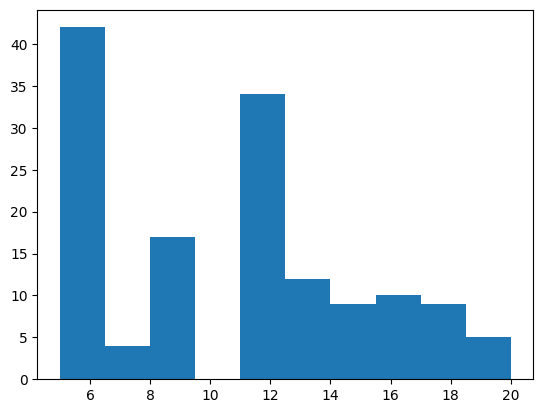

In [159]:
import matplotlib.pyplot as plt

plt.hist(match_counts.select("count"))
plt.show()

In [160]:
player_ids = match_counts.select("player_id").sort("player_id")  # guaranteed unique by aggregation
player_ids

player_id
str
"""76561197960690195"""
"""76561197961491680"""
"""76561197967432889"""
"""76561197973140692"""
"""76561197977105184"""
…
"""76561198995880877"""
"""76561199063068840"""
"""76561199063238565"""


In [161]:
from sklearn.model_selection import train_test_split

player_ids_train, player_ids_test = train_test_split(player_ids, test_size=0.2, random_state=410)

print("train player ids:", len(player_ids_train))
print("test player ids:", len(player_ids_test))

train player ids: 113
test player ids: 29


In [162]:
def load_segments(catalog, ids):
    dfs = []

    # remove players we do not want to include
    filtered_catalog_df = (
        catalog
        .filter(
            pl.col("player_id").is_in(ids)
        )
    )

    for match_id, map_id, player_id, filename in filtered_catalog_df.iter_rows():
        path = os.path.join(segment_directory, match_id, map_id, filename)
        df = (
            pl.read_csv(path)
            .with_columns([
                pl.lit(match_id).alias("match_id"),
                pl.lit(map_id).alias("map_id"),
                pl.lit(player_id).alias("player_id")
            ])
            .with_columns(
                pl.col("segment_id").floordiv(1_000).diff().fill_null(0).alias("round_restart")
            )
            # >>>>>>>>>>>>>>> FILTER TO ONLY FIRST ROUND >>>>>>>>>>>>>>> #
            # .filter(pl.col("segment_id") / 1_000 < 2)
            # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< #
            .fill_null(0)
            .fill_nan(0)
            .with_columns(
                (pl.col("match_id") + "_" + pl.col("map_id") + "_" + pl.col("player_id")).alias("sample_id")
            )
        )

        dfs.append(df)

    return pl.concat(dfs, how="vertical_relaxed")


train_data = (
    load_segments(catalog_df, player_ids_train)
    .filter(pl.col("team_num") == 2)
    .drop("team_num")
)
test_data = (
    load_segments(catalog_df, player_ids_test)
    .filter(pl.col("team_num") == 2)
    .drop("team_num")
)

segment_length = 5
print("[train]", train_data.shape[0] * segment_length / 3600, "hours")
print("[test] ", test_data.shape[0] * segment_length / 3600, "hours")

train_data.shape, test_data.shape

[train] 392.19166666666666 hours
[test]  100.23055555555555 hours


((282378, 113), (72166, 113))

In [51]:
# [train] 1459.1361111111112 hours
# [test]  359.8277777777778 hours
# ((525289, 112), (129538, 112))

In [163]:
class ZScaler:
    def __init__(self):
        self._ignored_columns = {"segment_id", "round_restart", "match_id", "map_id", "player_id", "sample_id"}
        self._params = None

    def fit(self, data):
        self._params = (
            data
            .select(
                *[
                    pl.mean(key).alias(f"{key}_mean")
                    for key in data.columns if key not in self._ignored_columns
                ],
                *[
                    pl.std(key).alias(f"{key}_std")
                    for key in data.columns if key not in self._ignored_columns
                ],
            )
        )

    def transform(self, data):
        transformed = (
            data
            .with_columns(
                self._params
            )
            .with_columns([
                (pl.col(key) - pl.col(f"{key}_mean")) / pl.col(f"{key}_std")
                for key in data.columns if key not in self._ignored_columns
            ])
            .select([key for key in data.columns])
        )
        return transformed


scaler = ZScaler()
scaler.fit(train_data)

train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)
train_data_scaled

segment_id,n_mouse_movements,mean_total_distance,std_total_distance,min_total_distance,max_total_distance,sum_total_distance,mean_straight_distance,std_straight_distance,min_straight_distance,max_straight_distance,sum_straight_distance,mean_duration,std_duration,min_duration,max_duration,sum_duration,mean_yaw_speed,mean_pitch_speed,mean_yaw_speed_acc,mean_pitch_speed_acc,std_yaw_speed,std_pitch_speed,std_yaw_speed_acc,std_pitch_speed_acc,min_yaw_speed,min_pitch_speed,min_yaw_speed_acc,min_pitch_speed_acc,max_yaw_speed,max_pitch_speed,max_yaw_speed_acc,max_pitch_speed_acc,keys_down_0,keys_down_1,keys_down_2,keys_down_3,…,sum_is_walking_transition,min_FORWARD_duration,max_FORWARD_duration,mean_FORWARD_duration,std_FORWARD_duration,sum_FORWARD_duration,min_LEFT_duration,max_LEFT_duration,mean_LEFT_duration,std_LEFT_duration,sum_LEFT_duration,min_RIGHT_duration,max_RIGHT_duration,mean_RIGHT_duration,std_RIGHT_duration,sum_RIGHT_duration,min_BACK_duration,max_BACK_duration,mean_BACK_duration,std_BACK_duration,sum_BACK_duration,min_FIRE_duration,max_FIRE_duration,mean_FIRE_duration,std_FIRE_duration,sum_FIRE_duration,min_is_walking_duration,max_is_walking_duration,mean_is_walking_duration,std_is_walking_duration,sum_is_walking_duration,entropy,match_id,map_id,player_id,round_restart,sample_id
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,str
13000,-1.31201,3.271528,-0.851675,6.255377,0.280194,-0.363374,4.975746,-0.926248,10.579194,0.657735,-0.237625,-0.88941,-1.056682,0.088706,-1.102293,-1.42506,8.202974,0.865086,8.657677,0.872995,-0.305648,-0.315856,-0.215807,-0.168984,0.585954,0.612719,0.362481,0.386675,3.808738,0.002185,4.156369,0.093708,1.992893,-1.376118,-1.056892,-0.555376,…,-0.663062,-0.578468,-1.005998,-0.800077,-0.657541,-1.144614,-0.359873,-0.719238,-0.605572,-0.562752,-0.873136,-0.341625,-0.70972,-0.586059,-0.56134,-0.887224,-0.352092,-0.461193,-0.42911,-0.30264,-0.625262,-0.25843,-0.302984,-0.286457,-0.167162,-0.369818,-0.437524,-0.599137,-0.540582,-0.392328,-0.664533,-0.935214,"""92695""","""1""","""76561197990140855""",1,"""92695_1_76561197990140855"""
13001,-1.428982,-0.622627,-0.851675,-0.0885,-0.944075,-0.92969,-0.725184,-0.926248,-0.104842,-1.018632,-0.916893,-1.099756,-1.056682,-0.370319,-1.164264,-1.44783,-0.22762,-0.195231,-0.115678,-0.092446,-0.305648,-0.315856,-0.215807,-0.168984,-0.037276,-0.032139,0.288543,0.254068,-0.496626,-0.474399,-0.282546,-0.275231,1.992893,-1.376118,-1.056892,-0.555376,…,-0.663062,-0.578468,-1.005998,-0.800077,-0.657541,-1.144614,-0.359873,-0.719238,-0.605572,-0.562752,-0.873136,-0.341625,-0.70972,-0.586059,-0.56134,-0.887224,-0.352092,-0.461193,-0.42911,-0.30264,-0.625262,-0.25843,-0.302984,-0.286457,-0.167162,-0.369818,-0.437524,-0.599137,-0.540582,-0.392328,-0.664533,-0.935214,"""92695""","""1""","""76561197990140855""",0,"""92695_1_76561197990140855"""
13002,-1.428982,-0.622627,-0.851675,-0.0885,-0.944075,-0.92969,-0.725184,-0.926248,-0.104842,-1.018632,-0.916893,-1.099756,-1.056682,-0.370319,-1.164264,-1.44783,-0.22762,-0.195231,-0.115678,-0.092446,-0.305648,-0.315856,-0.215807,-0.168984,-0.037276,-0.032139,0.288543,0.254068,-0.496626,-0.474399,-0.282546,-0.275231,1.992893,-1.376118,-1.056892,-0.555376,…,-0.663062,-0.578468,-1.005998,-0.800077,-0.657541,-1.144614,-0.359873,-0.719238,-0.605572,-0.562752,-0.873136,-0.341625,-0.70972,-0.586059,-0.56134,-0.887224,-0.352092,-0.461193,-0.42911,-0.30264,-0.625262,-0.25843,-0.302984,-0.286457,-0.167162,-0.369818,-0.437524,-0.599137,-0.540582,-0.392328,-0.664533,-0.935214,"""92695""","""1""","""76561197990140855""",0,"""92695_1_76561197990140855"""
13003,-1.428982,-0.622627,-0.851675,-0.0885,-0.944075,-0.92969,-0.725184,-0.926248,-0.104842,-1.018632,-0.916893,-1.099756,-1.056682,-0.370319,-1.164

In [164]:
def random_sample(data: pl.DataFrame, n_players: int = 2, n_samples: int = 2):
    selected_players = (
        data
        .select("player_id")
        .unique()
        .sample(n_players)
    )

    samples = []
    for (player,) in selected_players.iter_rows():
        player_sample_ids = (
            data
            .filter(pl.col("player_id") == player)
            .select("sample_id")
            .unique()
            .sample(n_samples)
        )
        player_samples = (
            data
            .filter(pl.col("sample_id").is_in(player_sample_ids))
        )
        samples.append(player_samples)

    samples = pl.concat(samples)
    return samples


random_sample(train_data_scaled, n_players=2, n_samples=2)

segment_id,n_mouse_movements,mean_total_distance,std_total_distance,min_total_distance,max_total_distance,sum_total_distance,mean_straight_distance,std_straight_distance,min_straight_distance,max_straight_distance,sum_straight_distance,mean_duration,std_duration,min_duration,max_duration,sum_duration,mean_yaw_speed,mean_pitch_speed,mean_yaw_speed_acc,mean_pitch_speed_acc,std_yaw_speed,std_pitch_speed,std_yaw_speed_acc,std_pitch_speed_acc,min_yaw_speed,min_pitch_speed,min_yaw_speed_acc,min_pitch_speed_acc,max_yaw_speed,max_pitch_speed,max_yaw_speed_acc,max_pitch_speed_acc,keys_down_0,keys_down_1,keys_down_2,keys_down_3,…,sum_is_walking_transition,min_FORWARD_duration,max_FORWARD_duration,mean_FORWARD_duration,std_FORWARD_duration,sum_FORWARD_duration,min_LEFT_duration,max_LEFT_duration,mean_LEFT_duration,std_LEFT_duration,sum_LEFT_duration,min_RIGHT_duration,max_RIGHT_duration,mean_RIGHT_duration,std_RIGHT_duration,sum_RIGHT_duration,min_BACK_duration,max_BACK_duration,mean_BACK_duration,std_BACK_duration,sum_BACK_duration,min_FIRE_duration,max_FIRE_duration,mean_FIRE_duration,std_FIRE_duration,sum_FIRE_duration,min_is_walking_duration,max_is_walking_duration,mean_is_walking_duration,std_is_walking_duration,sum_is_walking_duration,entropy,match_id,map_id,player_id,round_restart,sample_id
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,str
1000,-0.142288,-0.029172,-0.044088,-0.0885,-0.096046,0.105965,0.325385,0.439482,-0.104842,0.256445,0.585216,-0.411351,-0.305276,-0.140807,-0.575536,-0.62812,0.435725,0.047307,0.483064,0.129258,-0.142664,-0.090769,-0.130876,-0.088234,-0.037276,-0.032139,-11.273834,-5.698547,1.201879,0.040956,1.514052,0.30513,1.42726,-0.739577,-1.012733,-0.555376,…,-0.663062,0.101651,-0.350518,-0.100875,-0.657541,-0.626065,-0.359873,-0.719238,-0.605572,-0.562752,-0.873136,-0.341625,-0.70972,-0.586059,-0.56134,-0.887224,-0.352092,-0.461193,-0.42911,-0.30264,-0.625262,-0.126803,-0.18743,-0.159615,-0.167162,0.443393,-0.437524,-0.599137,-0.540582,-0.392328,-0.664533,-0.924756,"""93110""","""2""","""76561198258044780""",0,"""93110_2_76561198258044780"""
1001,-0.376233,-0.183494,0.18504,-0.085906,0.188845,-0.354933,-0.073309,0.525429,-0.104842,0.568498,-0.217853,-0.199943,0.077066,-0.140807,0.044177,-0.571195,-0.165134,-0.133835,-0.11387,-0.079291,-0.139854,-0.216781,-0.160971,-0.128071,-0.037276,-0.032139,-0.047816,0.115372,-0.207175,-0.333891,-0.205507,-0.19612,0.734305,0.108781,-1.056892,-0.555376,…,-0.663062,0.949184,0.466312,0.77044,-0.657541,-0.626065,-0.359873,-0.719238,-0.605572,-0.562752,-0.873136,-0.341625,-0.70972,-0.586059,-0.56134,-0.887224,-0.352092,-0.461193,-0.42911,-0.30264,-0.625262,-0.25843,-0.302984,-0.286457,-0.167162,-0.369818,-0.437524,-0.599137,-0.540582,-0.392328,-0.664533,-0.935214,"""93110""","""2""","""76561198258044780""",0,"""93110_2_76561198258044780"""
1002,-1.195038,0.281113,-0.102508,0.394569,-0.469053,-0.666834,0.60528,0.132413,0.666489,-0.357207,-0.599842,0.583011,-0.52731,2.38383,-0.54455,-1.083514,-0.019353,0.094278,-0.113474,-0.085673,-0.165978,0.056062,-0.181332,-0.089702,-0.026833,-0.032139,0.184751,0.080451,-0.31822,-0.146465,-0.234414,-0.169692,-0.765657,1.878454,-1.056892,-0.555376,…,-0.663062,2.769809,2.220983,2.642152,-0.657541,-0.626065,-0.359873,-0.719238,-0.605572,-0.562752,-0.873136,-0.341625,-0.70972,-0.586059,-0.56134,-0.887224,-0.352092,-0.461193,-0.42911,-0.30264,-0.625262,-0.25843,-0.302984,-0.286457,-0.167162,-0.369818,-0.437524,-0.599137,-0.540582,-0.392328,-0.664533,-0.935214,"""93110""","""2""","""76561198258044780""",0,"""93110_2_76561198258044780"""
1003,-1.428982,-0.622627,-0.851675,-0.0885,-0.944075,-0.92969,-0.725184,-0.926248,-0.104842,-1.018632,-0.916893,-1.099756,-1.056682,-0.370319,-1.164264,-1.44783,-0.22762,

In [165]:
import numpy as np


def random_batch(data: pl.DataFrame, n_players: int, n_samples: int):
    x, y = [], []
    df = random_sample(data, n_players=n_players, n_samples=n_samples)
    groups = df.group_by("player_id", "sample_id")
    for (player_id, sample_id), group_df in groups:
        group_df = (
            group_df
            # drop non-feature columns and convert to torch
            .drop("match_id", "map_id", "player_id", "segment_id", "sample_id")
        )
        tensor = group_df.to_torch().float().to(device)
        tensor = torch.nan_to_num(tensor, 0.0)

        x.append(tensor)
        y.append(player_id)
    y = np.array(y, dtype=int)
    return x, y


x, y = random_batch(train_data_scaled, n_players=8, n_samples=2)
print(len(x), len(y))

16 16


In [166]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import torch


class PlayerEncoder(torch.nn.Module):
    def __init__(self, input_size: int, lstm_size: int = 16, fc_size: int = 128, num_layers: int = 1,
                 bidirectional: bool = False):
        super().__init__()
        self._num_lstm_layers = num_layers
        self._bidirectional = bidirectional
        self.lstm = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=lstm_size,
            num_layers=self._num_lstm_layers,
            batch_first=True,
            bidirectional=self._bidirectional,
        )
        self.fc = torch.nn.Linear(lstm_size * 2 * (2 if bidirectional else 1), fc_size)

    def embedding(self, x):
        _, (h, c) = self.lstm(x)
        if self._bidirectional:
            hf, cf = h[self._num_lstm_layers - 1], c[self._num_lstm_layers - 1]
            hb, cb = h[-1], c[-1]
            embedding = torch.cat([hf, cf, hb, cb], dim=-1)
        else:
            h, c = h[-1], c[-1]
            embedding = torch.cat([h, c], dim=-1)
        embedding = self.fc(embedding)
        # embedding = torch.nn.functional.relu(embedding)

        # normalize embedding
        embedding = torch.nn.functional.normalize(embedding, p=2, dim=1)

        return embedding

    def forward(self, batch):
        packed_sprays = self._pack_sprays(batch)
        embedding = self.embedding(packed_sprays)
        return embedding

    @staticmethod
    def _pack_sprays(batch):
        lengths = torch.tensor([s.shape[0] for s in batch], dtype=torch.long)
        padded_sprays = pad_sequence(batch, batch_first=True)
        packed_sprays = pack_padded_sequence(padded_sprays, lengths, batch_first=True, enforce_sorted=False)
        return packed_sprays

In [167]:
model = PlayerEncoder(input_size=108).to(device)

test_batch, _ = random_batch(train_data_scaled, n_players=8, n_samples=2)

test_embeddings = model(test_batch)
print(test_embeddings.shape)
print(test_embeddings)

torch.Size([16, 128])
tensor([[-0.0414, -0.0827,  0.0132,  ...,  0.0710,  0.0524,  0.0841],
        [-0.0600, -0.0818,  0.0796,  ...,  0.0615,  0.1033,  0.0081],
        [-0.0816, -0.1002,  0.0891,  ..., -0.0452, -0.0537, -0.0043],
        ...,
        [-0.1306, -0.0121,  0.1836,  ...,  0.1121,  0.0749,  0.0799],
        [-0.0768, -0.0981,  0.0866,  ..., -0.0434, -0.0628, -0.0206],
        [ 0.0664,  0.0897, -0.1223,  ...,  0.0449, -0.1507,  0.0942]],
       device='mps:0', grad_fn=<DivBackward0>)


In [168]:
class TICLLoss(torch.nn.Module):
    """Triplet + Intra-CLuster Loss function."""

    def __init__(self, margin: float, p: float = 2.0, eps: float = 1e-7, lamda: float = 0.1):
        super().__init__()
        self._margin = margin
        self._p = p
        self._eps = eps
        self._lamda = lamda
        self._triplet_loss = torch.nn.TripletMarginLoss(margin=margin, p=p, eps=eps)

    def forward(self, embeddings, labels):
        triplets = self.mine_triplets(embeddings, labels)
        if not triplets:
            triplet_loss = 0
        else:
            anchor, positive, negative = triplets
            anchor, positive, negative = embeddings[anchor], embeddings[positive], embeddings[negative]
            triplet_loss = self._triplet_loss(anchor, positive, negative)
        intra_cluster_loss = self._intra_cluster_loss(embeddings, labels)
        return triplet_loss + (intra_cluster_loss * self._lamda)

    # noinspection PyMethodMayBeStatic
    def _intra_cluster_loss(self, embeddings, labels):
        # Compute pairwise Euclidean distance between all embeddings in the batch
        dist_matrix = torch.cdist(embeddings, embeddings, p=2)  # shape: (batch_size, batch_size)

        # Create a mask that identifies the pairs belonging to the same class
        same_class_mask = torch.from_numpy(labels[:, None] == labels[None, :]).to(device)

        # Apply the mask to the distance matrix (only consider intra-class distances)
        intra_class_distances = dist_matrix * same_class_mask.float()  # shape: (batch_size, batch_size)

        # Sum up the pairwise distances for each class
        loss = intra_class_distances.sum() / (same_class_mask.sum() + 1e-6)  # Normalize by the number of valid pairs
        return loss

    # noinspection PyMethodMayBeStatic
    def mine_triplets(self, embeddings, labels):
        labels = torch.tensor(labels.astype(int), device=device)
        dist = torch.cdist(embeddings, embeddings, p=self._p)  # Compute all pairwise distances

        # Mask for same-player pairs
        same_player_mask = labels[:, None] == labels[None, :]
        diff_player_mask = ~same_player_mask

        # Remove self-comparisons
        self_mask = torch.eye(len(labels), device=device, dtype=torch.bool)
        same_player_mask &= ~self_mask

        # Get hardest positives (closest among same-player samples)
        positive_distances = dist.clone()
        positive_distances[~same_player_mask] = float("inf")  # Ignore non-positives
        positive_indices = torch.argmin(positive_distances, dim=1)

        # Get semi-hard negatives (hardest negative within margin)
        negative_distances = dist.clone()
        negative_distances[~diff_player_mask] = float("inf")  # Ignore non-negatives

        anchors = torch.arange(len(labels), device=device)
        pos_distances = dist[anchors, positive_indices]  # d(a, p)

        semi_hard_mask = (negative_distances > pos_distances[:, None]) & \
                         (negative_distances < pos_distances[:, None] + self._margin)

        # Ensure at least one valid negative exists per anchor
        has_valid_neg = semi_hard_mask.any(dim=1)

        # Get hardest semi-hard negative per anchor
        if has_valid_neg.any():
            negative_distances[~semi_hard_mask] = float("inf")
            negative_indices = torch.argmin(negative_distances, dim=1)
        else:
            return None  # No valid triplets found

        # Filter out samples where no valid negative was found
        valid_triplets = has_valid_neg
        if valid_triplets.sum() == 0:
            return None  # No valid triplets found

        anchor = anchors[valid_triplets]
        positive = positive_indices[valid_triplets]
        negative = negative_indices[valid_triplets]
        return anchor, positive, negative

In [169]:
from torch.utils.tensorboard import SummaryWriter

model_params = {
    "input_size": 108,
    "lstm_size": 64,
    "fc_size": 64,
    "num_layers": 1,
    "bidirectional": False,
}
model = PlayerEncoder(**model_params).to(device)
epochs_trained = 0

loss_params = {
    "margin": 2,
    "p": 2,
    "eps": 1e-7,
    "lamda": 0.1,
}
optimizer_params = {
    "lr": 1e-2,
}
loss_fn = TICLLoss(**loss_params)
optimizer = torch.optim.Adam(model.parameters(), **optimizer_params)

writer = SummaryWriter()
writer.add_text("model_params", str(model_params))
writer.add_text("loss_params", str(loss_params))
writer.add_text("optimizer_params", str(optimizer_params))

In [171]:
def train_epoch(n_batches: int, n_players: int, n_samples: int, summary_writer: SummaryWriter = None):
    model.train()

    avg_loss = 0.0

    for batch in range(n_batches):
        batch_features, labels = random_batch(train_data_scaled, n_players=n_players, n_samples=n_samples)

        embeddings = model(batch_features)
        loss = loss_fn(embeddings, labels)

        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if summary_writer:
            summary_writer.add_scalar("loss/train", loss.item(), epochs_trained)

    return avg_loss / n_batches


def train(n_epochs: int, summary_writer: SummaryWriter = None):
    global epochs_trained

    for _ in range(n_epochs):
        print("epoch", epochs_trained)
        loss = train_epoch(n_batches=32, n_players=24, n_samples=5, summary_writer=summary_writer)
        epochs_trained += 1
        print(loss)

    if summary_writer:
        writer.flush()

In [ ]:
train(100, summary_writer=writer)

epoch 0
2.031255103647709
epoch 1
2.0051185339689255
epoch 2
1.9962454251945019
epoch 3
1.9442472979426384
epoch 4
1.8681245669722557
epoch 5


In [26]:
torch.save(model.state_dict(), "5mnk-model-128d.pth")

In [27]:
model.load_state_dict(torch.load("./5mnk-model-128d.pth", weights_only=True))

<All keys matched successfully>

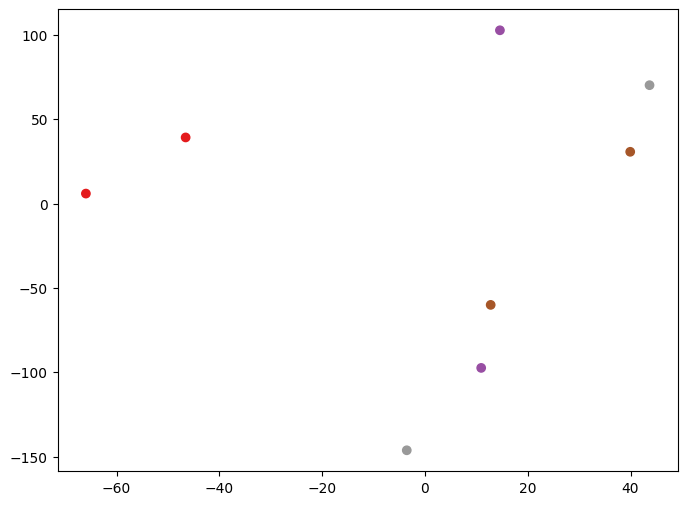

In [81]:
from sklearn.manifold import TSNE


def plot_embeddings(embeddings, labels):
    # Convert string labels to unique numeric indices
    unique_labels = np.unique(labels)  # Get unique label names
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    label_indices = np.array([label_to_index[label] for label in labels])

    # Generate distinct colors
    cmap = plt.get_cmap("Set1", len(unique_labels))
    colors = [cmap(idx) for idx in label_indices]  # Assign colors based on indices

    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c=colors, marker="o")

    # Add legend
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=8)
    #            for i in range(len(unique_labels))]
    # plt.legend(handles, unique_labels, title="Player IDs")
    plt.show()


test_features, test_labels = random_batch(test_data_scaled, n_samples=2, n_players=4)

model.eval()
test_embeddings = model(test_features).cpu().detach().numpy()
# print(test_embeddings)

tsne = TSNE(n_components=2, random_state=0, perplexity=3)
tsne_embeddings = tsne.fit_transform(test_embeddings)

plot_embeddings(tsne_embeddings, test_labels)

In [73]:
def all_samples(data):
    groups = data.group_by(["sample_id"])
    tensors = [
        (
            group
            # drop non-feature columns and convert to torch
            .drop("player_id", "match_id", "map_id", "player_id", "segment_id", "sample_id")
            .to_torch()
            .float()
            .to(device)
        )
        for _, group in groups
    ]
    # fill nan columns
    tensors = [torch.nan_to_num(tensor, 0.0) for tensor in tensors]
    labels = [group.select("player_id").to_series().first() for _, group in groups]
    labels = np.array(labels)
    return tensors, labels

In [74]:
model.eval()

# get train embeddings
features, train_labels = all_samples(train_data_scaled)
train_embeddings = []
for batch_idx in range(0, len(features), 64):
    train_embeddings.extend(model(features[batch_idx:batch_idx + 64]).cpu().detach().numpy())

# get test embeddings
features, test_labels = all_samples(test_data_scaled)
test_embeddings = []
for batch_idx in range(0, len(features), 64):
    test_embeddings.extend(model(features[batch_idx:batch_idx + 64]).cpu().detach().numpy())

all_embeddings = np.concat([train_embeddings, test_embeddings])
all_labels = np.concatenate([train_labels, test_labels])

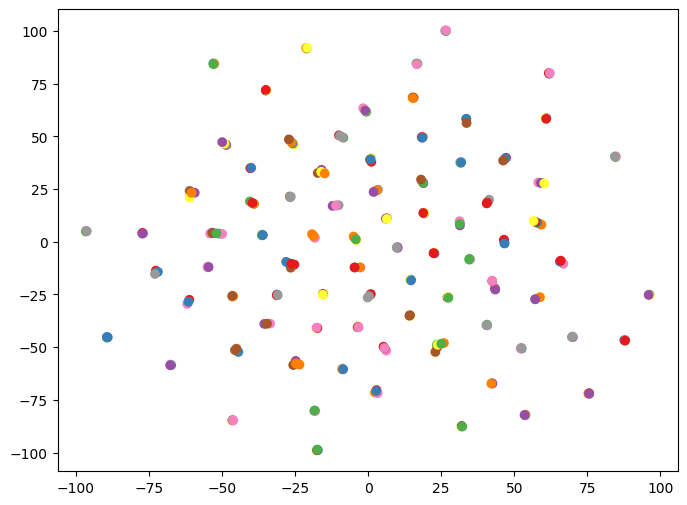

In [75]:
tsne = TSNE(n_components=2, random_state=0, perplexity=2)
tsne_embeddings = tsne.fit_transform(np.array(train_embeddings))
plot_embeddings(tsne_embeddings, train_labels)

In [76]:
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from scipy.stats import entropy

kmeans = KMeans(n_clusters=84)
# dbscan = DBSCAN(eps=0.2, min_samples=40)
# dbscan_labels = dbscan.fit_predict(all_embeddings)
cluster_labels = kmeans.fit_predict(all_embeddings)


def confusion_matrix(left, right):
    left_map = {label: i for i, label in enumerate(np.unique(left))}
    right_map = {label: i for i, label in enumerate(np.unique(right))}
    cm = np.zeros(shape=(len(left_map.keys()), len(right_map.keys())), dtype=int)
    for l, r in zip(left, right):
        l_idx = left_map[l]
        r_idx = right_map[r]
        cm[l_idx, r_idx] += 1
    cm = pd.DataFrame(cm, index=left_map.keys(), columns=right_map.keys())
    return cm


cm = confusion_matrix(all_labels, cluster_labels)
entropy(cm, axis=1)

array([1.60943791, 1.38629436, 1.38629436, 1.38629436, 1.09861229,
       1.09861229, 1.09861229, 1.33217904, 0.63651417, 1.09861229,
       1.09861229, 1.09861229, 1.09861229, 1.38629436, 1.38629436,
       1.38629436, 1.09861229, 1.09861229, 1.09861229, 1.56071041,
       1.38629436, 1.09861229, 1.09861229, 1.03972077, 1.60943791,
       1.09861229, 1.09861229, 1.09861229, 1.60943791, 1.09861229,
       1.38629436, 1.09861229, 1.38629436, 1.09861229, 1.38629436,
       1.56071041, 1.38629436, 1.09861229, 1.09861229, 1.38629436,
       1.60943791, 1.09861229, 1.09861229, 1.09861229, 1.09861229,
       1.38629436, 1.09861229, 1.09861229, 1.38629436, 1.09861229,
       1.38629436, 1.38629436, 1.03972077, 1.33217904, 1.09861229,
       1.38629436, 1.38629436, 1.38629436, 1.09861229, 1.09861229,
       1.09861229, 1.09861229, 1.09861229, 1.09861229, 1.38629436,
       1.38629436, 1.03972077, 1.38629436, 1.38629436, 1.09861229,
       1.09861229, 1.38629436, 1.09861229, 1.09861229, 1.09861

In [77]:
from sklearn.metrics import silhouette_score

print("silhouette scores")
train_silhouette_score = silhouette_score(train_embeddings, train_labels)
print("train:", train_silhouette_score)
test_silhouette_score = silhouette_score(test_embeddings, test_labels)
print("test: ", test_silhouette_score)
all_silhouette_score = silhouette_score(all_embeddings, all_labels)
print("all:  ", all_silhouette_score)

silhouette scores
train: -0.3095947
test:  -0.118826106
all:   -0.2804454


In [78]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier

# clf = RadiusNeighborsClassifier(radius=1, metric="euclidean", outlier_label="0")
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(all_embeddings, all_labels)

pred = clf.predict(all_embeddings)
accuracy = accuracy_score(all_labels, pred)
print(accuracy)
print(classification_report(all_labels, pred, zero_division=0))

0.20441988950276244
                   precision    recall  f1-score   support

76561197960690195       0.19      0.60      0.29         5
76561197961491680       0.25      1.00      0.40         4
76561197980122997       0.13      1.00      0.23         4
76561197981355847       0.22      0.50      0.31         4
76561197983031494       0.17      0.67      0.27         3
76561197983772557       0.20      0.67      0.31         3
76561197989430253       0.16      1.00      0.27         3
76561197990140855       0.31      0.80      0.44         5
76561197990793708       0.22      0.67      0.33         3
76561197991272318       0.27      1.00      0.43         3
76561197996370184       0.33      0.67      0.44         3
76561197997351207       0.00      0.00      0.00         3
76561198002775202       0.00      0.00      0.00         3
76561198015308884       0.20      0.50      0.29         4
76561198022284035       0.22      0.50      0.31         4
76561198029235071       0.08      0

In [79]:
pred = clf.predict(test_embeddings)
accuracy = accuracy_score(test_labels, pred)
print(accuracy)
print(classification_report(test_labels, pred, zero_division=0))

0.2191780821917808
                   precision    recall  f1-score   support

76561197960690195       0.00      0.00      0.00         0
76561197961491680       0.00      0.00      0.00         0
76561197980122997       0.50      1.00      0.67         4
76561197981355847       0.00      0.00      0.00         0
76561197983031494       0.00      0.00      0.00         0
76561197983772557       0.00      0.00      0.00         0
76561197989430253       0.00      0.00      0.00         0
76561197990140855       0.00      0.00      0.00         0
76561197990793708       0.00      0.00      0.00         0
76561197996370184       0.67      0.67      0.67         3
76561198015308884       0.00      0.00      0.00         0
76561198022284035       0.00      0.00      0.00         0
76561198029235071       0.67      0.50      0.57         4
76561198039334036       0.00      0.00      0.00         0
76561198045739761       0.25      0.33      0.29         3
76561198045898864       0.00      0.

In [80]:
pred = clf.predict(train_embeddings)
accuracy = accuracy_score(train_labels, pred)
print(accuracy)
print(classification_report(train_labels, pred, zero_division=0))

0.20069204152249134
                   precision    recall  f1-score   support

76561197960690195       0.27      0.60      0.38         5
76561197961491680       0.31      1.00      0.47         4
76561197980122997       0.00      0.00      0.00         0
76561197981355847       0.25      0.50      0.33         4
76561197983031494       0.18      0.67      0.29         3
76561197983772557       0.29      0.67      0.40         3
76561197989430253       0.21      1.00      0.35         3
76561197990140855       0.36      0.80      0.50         5
76561197990793708       0.33      0.67      0.44         3
76561197991272318       0.27      1.00      0.43         3
76561197996370184       0.00      0.00      0.00         0
76561197997351207       0.00      0.00      0.00         3
76561198002775202       0.00      0.00      0.00         3
76561198015308884       0.22      0.50      0.31         4
76561198022284035       0.29      0.50      0.36         4
76561198029235071       0.00      0

In [154]:
np.save("./res/embeddings/embeddings.npy", all_embeddings)
np.save("./res/embeddings/labels.npy", all_labels)